In [1]:
from sportsipy.nhl.teams import Teams
from scipy.stats import pearsonr
from scipy.stats import skew,kurtosis
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import statistics
from matplotlib import pyplot as plt
import collections

In [2]:
# https://towardsdatascience.com/web-scraping-nba-stats-4b4f8c525994
def getGa(abbr,year):
    url = 'https://www.hockey-reference.com/teams/' + abbr + '/' + str(year) + '.html'
    html = urlopen(url)
    soup = BeautifulSoup(html,features="lxml")
    
    # avoid the first header row
    rows = soup.findAll('tr')[1:]
    all_stats = [[td.getText() for td in rows[i].findAll('td')]for i in range(len(rows))]
    all_stats2 = [e for e in all_stats if e]
    all_stats3=[x for x in all_stats2 if len(x)>3]
    team_stats = all_stats3[0]
    if (year >= 2006) or (year == 1999):
        goals_against = team_stats[8]
    elif (year >= 2000) and (year <= 2004):
        goals_against = team_stats[9]
    else:
        goals_against = team_stats[7]
    return(goals_against)

In [4]:
minDelta = 0
maxDelta = 0
deltaList = []
for year in range(1945, 2021):
    if year == 2005:
        continue
    teams = list(Teams(year))
    statd = {}
    for i,team in enumerate(teams[0:len(teams)]):
        G = team.games_played
        WinPct = round(100*.5*team.points/G,3)
        GF = team.goals_for
        GA = int(getGa(team.abbreviation,year))
        statd[i] = {'Team' : team.name,
                    'WinPct' : WinPct,
                    'GfrPct' : round(100*GF/(GF+GA),3)}
        
    df = pd.DataFrame(statd)
    df = df.transpose()

    l = df[['WinPct','GfrPct']].values.tolist()
    seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
    index = [seq.index(v) for v in l]
    df['Iwin'] =  index

    l = df[['GfrPct','WinPct']].values.tolist()
    seq = sorted(l, key=lambda x: ((-float(x[0])), (-float(x[1]))))
    index = [seq.index(v) for v in l]
    df['Igfp'] =  index


    df['Delta'] = df['Igfp']-df['Iwin']
    x = list(df['Delta'])
    
    locMinDelta = int(min(df['Delta']))
    locMinTeam = df.Team[df['Delta'] == locMinDelta]
    locMinTeam = locMinTeam.to_string(index=False)
    locMaxDelta = int(max(df['Delta']))
    locMaxTeam = df.Team[df['Delta'] == locMaxDelta]
    locMaxTeam = locMaxTeam.to_string(index=False)
    
    if maxDelta == minDelta:
        minDelta = locMinDelta
        maxDelta = locMaxDelta
        minTeam = locMinTeam
        maxTeam = locMaxTeam
        minYear = year
        maxYear = year
        print('%s %s: %s (new minDelta) (new maxDelta)' % (year,locMinTeam,round(minDelta,3)))
    if locMinDelta < minDelta:
        minDelta= locMinDelta
        minTeam = locMinTeam
        minYear = year
        print('%s %s: %s (new min)' % (year,locMinTeam,round(minDelta,3)))
    if locMaxDelta > maxDelta:
        maxDelta = locMaxDelta
        maxTeam = locMaxTeam
        maxYear = year
        print('%s %s: %s (new max)' % (year,locMaxTeam,round(maxDelta,3)))
    
    for d in x:
        deltaList.append(d)

deltaList=sorted(deltaList,reverse=False)

1945   Montreal Canadiens
   Detroit Red Wings
 Toronto Maple Leafs
       Boston Bruins
 Chicago Black Hawks
    New York Rangers: 0 (new minDelta) (new maxDelta)
1946  Chicago Black Hawks
 Toronto Maple Leafs: -1 (new minDelta) (new maxDelta)
1963  Montreal Canadiens: -2 (new min)
1965  Montreal Canadiens: 2 (new max)
1968  Detroit Red Wings: -4 (new min)
1968  Los Angeles Kings: 3 (new max)
1976  Los Angeles Kings: 4 (new max)
1985  Winnipeg Jets: 5 (new max)
1986  Chicago Black Hawks: 6 (new max)
1994  Buffalo Sabres: -6 (new min)
1994  Pittsburgh Penguins: 10 (new max)
2002  Vancouver Canucks: -7 (new min)
2006  Minnesota Wild: -10 (new min)
2011  New York Rangers: -12 (new min)
2012  Montreal Canadiens: -13 (new min)
2015  Anaheim Ducks: 14 (new max)


In [5]:
print('max: ' + str(max(deltaList)))
print('min: ' + str(min(deltaList)))
print('median: ' + str(statistics.median(deltaList)))
print('mean: ' + str(round(statistics.mean(deltaList),2)))
print('mode: ' + str(statistics.mode(deltaList)))
print('pstdev: ' + str(round(statistics.pstdev(deltaList),2)))
print('pvariance: ' + str(round(statistics.pvariance(deltaList),2)))
print('skew: ' + str(round(skew(deltaList,bias=False),2)))
print('kurtosis-3: ' + str(round(kurtosis(deltaList,bias=False)-3,2)))

quartiles=[round(q, 2) for q in statistics.quantiles(deltaList, n=4)]
print('quartiles(excl): '+ str(quartiles))
deciles=[round(q, 2) for q in statistics.quantiles(deltaList, n=10)]
print('deciles(excl): '+ str(deciles))
print('count: ' + str(len(deltaList)))

max: 14
min: -13
median: 0
mean: 0
mode: 0
pstdev: 2.3
pvariance: 5.29
skew: -0.08
kurtosis-3: 1.76
quartiles(excl): [-1.0, 0.0, 1.0]
deciles(excl): [-2.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0]
count: 1379


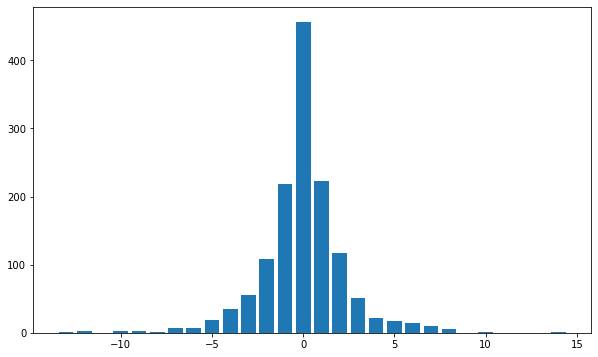

In [6]:
counter=collections.Counter(deltaList)
dely = list(counter.values())
delx = list(counter.keys())
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(delx,dely)
plt.show()

In [7]:
pd.DataFrame(list(zip(delx,dely)),columns=['delta','freq'])

,delta,freq
0,-13,1
1,-12,2
2,-10,2
3,-9,2
4,-8,1
5,-7,7
6,-6,7
7,-5,19
8,-4,35
9,-3,56
